In [20]:
import pandas as pd
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.nonparametric import kaplan_meier_estimator

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 8)
plt.style.use("ggplot")

## About the data

We are working with the well known Veteran's Lung Cancer data, collected and made public for research a few years ago. This dataset contains information relevant to a clinical study that monitored cancer patients and registered the probability of survival after receiving treatment. It contains the following columns.

- Treatment: denotes the type of lung cancer treatment; standard and test drug.
- Celltype: denotes the type of cell involved; squamous, small cell, adeno, large.
- Karnofsky_score: is the [Karnofsky score](http://www.npcrc.org/files/news/karnofsky_performance_scale.pdf).
- Diag: is the time since diagnosis in months.
- Age: is the age in years.
- Prior_Therapy: denotes any prior therapy; none or yes.
- Status: denotes the status of the patient as dead or alive; dead or alive.
- Survival_in_days: is the survival time in days since the treatment.

The key question to answer in these type of analysis is: "What's the probability of a given patient to be alive in time _t_? 

This is a complicated problem as for example, if we contact patient X at time _t5_, we are certain that he/she was alive at _t5_, but we can't be certain this patient will still be alive at _t10_. This is why we depend heavily in probability and accept the fact that we are working with censored data. 


In [2]:
data_x, data_y = load_veterans_lung_cancer()

In [3]:
data_x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard


In [4]:
data_y[:5]

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [5]:
# Creating an EDA Df for simplicity
eda_df = pd.concat(
   [ 
       data_x,
       pd.Series(data_y["Status"], name="Status"),
       pd.Series(data_y["Survival_in_days"], name="Survival_in_days")
    ],
    axis=1
)

## EDA



In [6]:
eda_df.describe()

,Age_in_years,Karnofsky_score,Months_from_Diagnosis,Survival_in_days
count,137.000000,137.000000,137.000000,137.000000
mean,58.306569,58.569343,8.773723,121.627737
std,10.541628,20.039592,10.612141,157.816722
min,34.000000,10.000000,1.000000,1.000000
25%,51.000000,40.000000,3.000000,25.000000
50%,62.000000,60.000000,5.000000,80.000000
75%,66.000000,75.000000,11.000000,144.000000
max,81.000000,99.000000,87.000000,999.000000


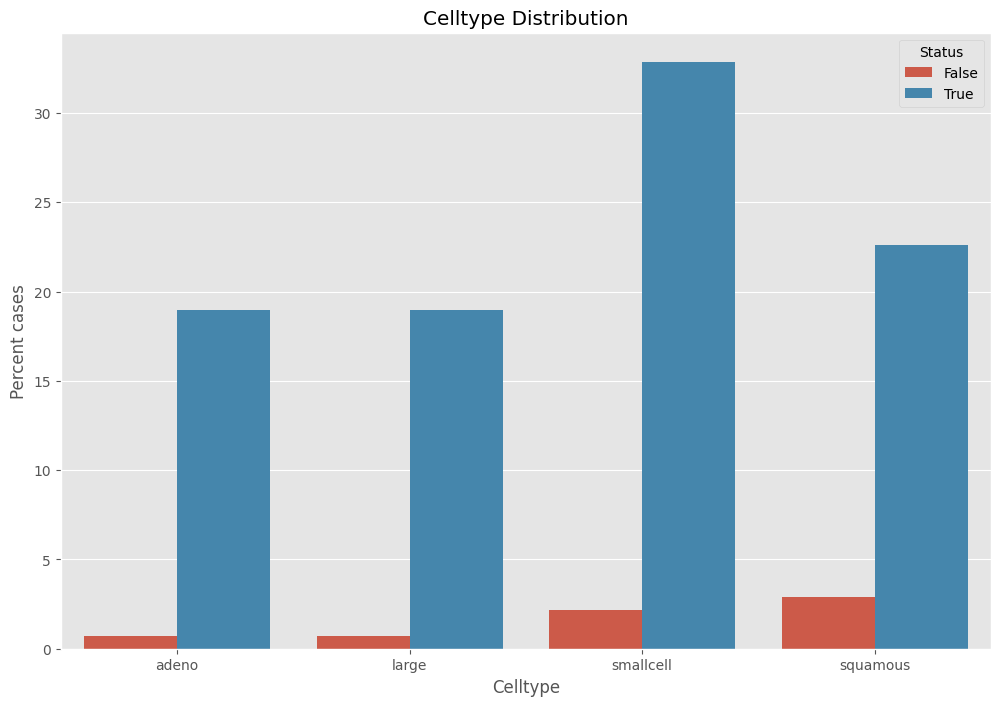

In [7]:
# Celltype distribution
sns.countplot(
    data=eda_df,
    x='Celltype', 
    hue="Status",
    stat="percent"
)
plt.title('Celltype Distribution')
plt.xlabel('Celltype')
plt.ylabel('Percent cases')
plt.show()


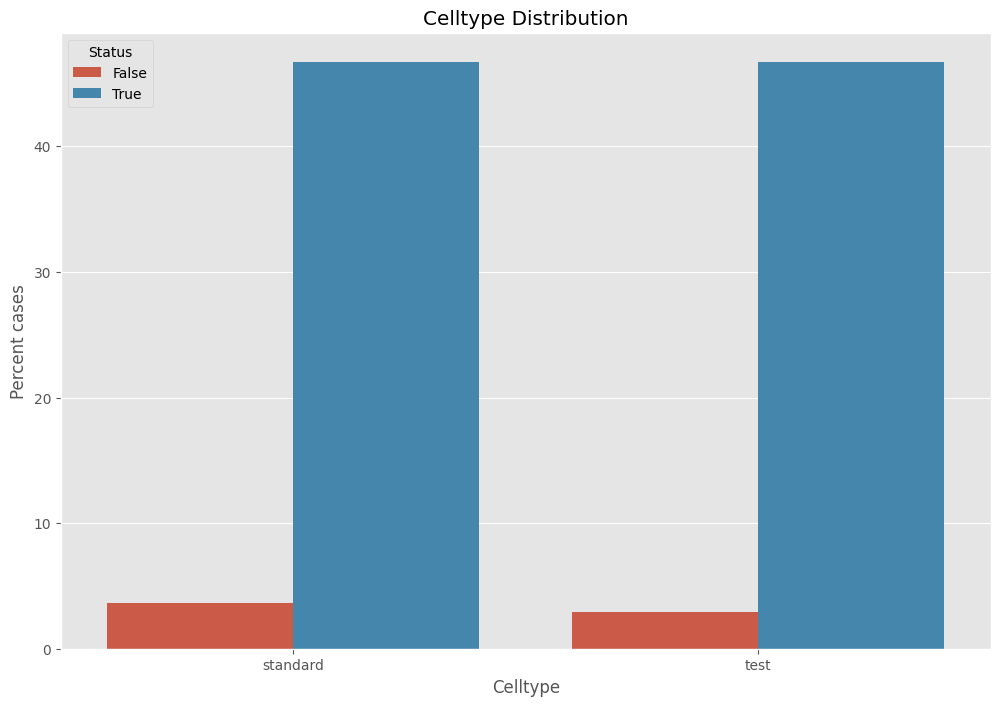

In [24]:
# Celltype distribution
sns.countplot(
    data=eda_df,
    x='Treatment', 
    hue="Status",
    stat="percent"
)
plt.title('Celltype Distribution')
plt.xlabel('Celltype')
plt.ylabel('Percent cases')
plt.show()

In [14]:
def dist_histogram(
        df: pd.DataFrame,
        col: str,
        bins: int = 30,
        hue_: str | None = None,
        **kwargs
    ):
    if not hue_:
        sns.histplot(df[col], bins=bins, kde=True, **kwargs)
        
    
    else:
        _df = df[[hue_, col]].melt([hue_], var_name='melt',  value_name='vals')
        sns.histplot(
            data=_df,
            x="vals",
            hue=hue_,
            bins=bins,
            kde=True,
            **kwargs
        )

    plt.title(f'{col} Distribution by {hue_}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

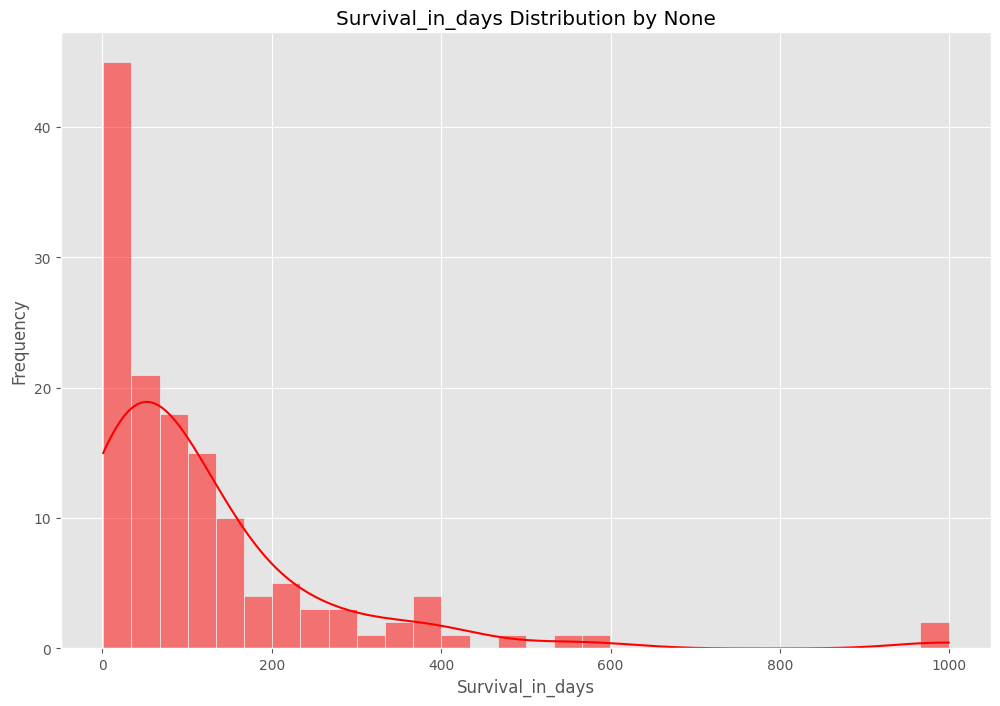

In [9]:
dist_histogram(eda_df, "Survival_in_days", color="r")

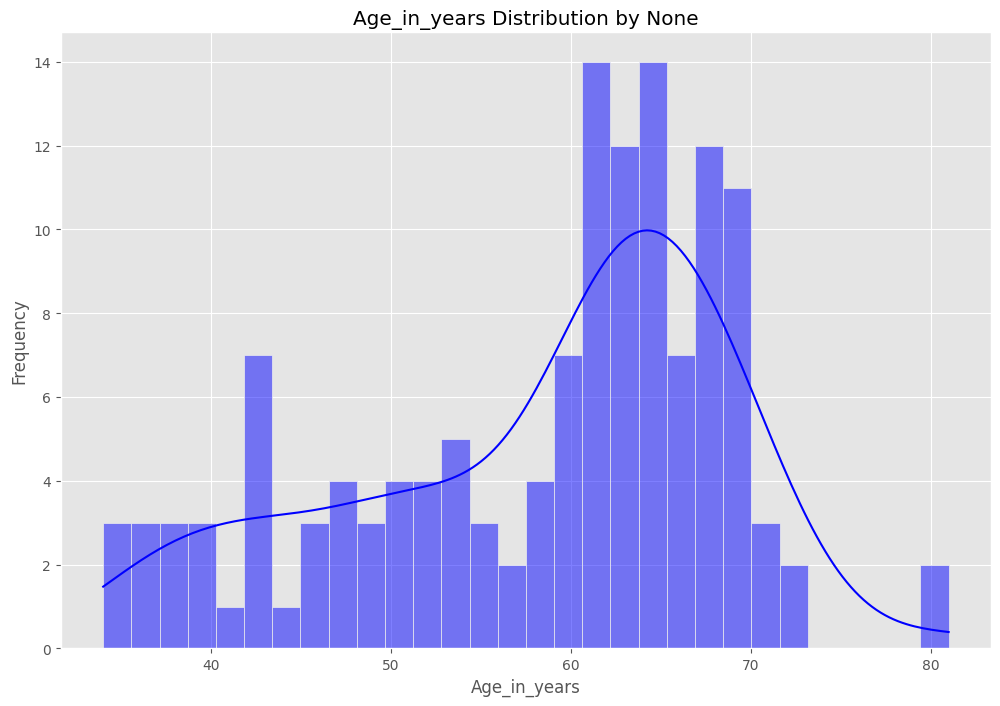

In [10]:
dist_histogram(eda_df, "Age_in_years", color="b")

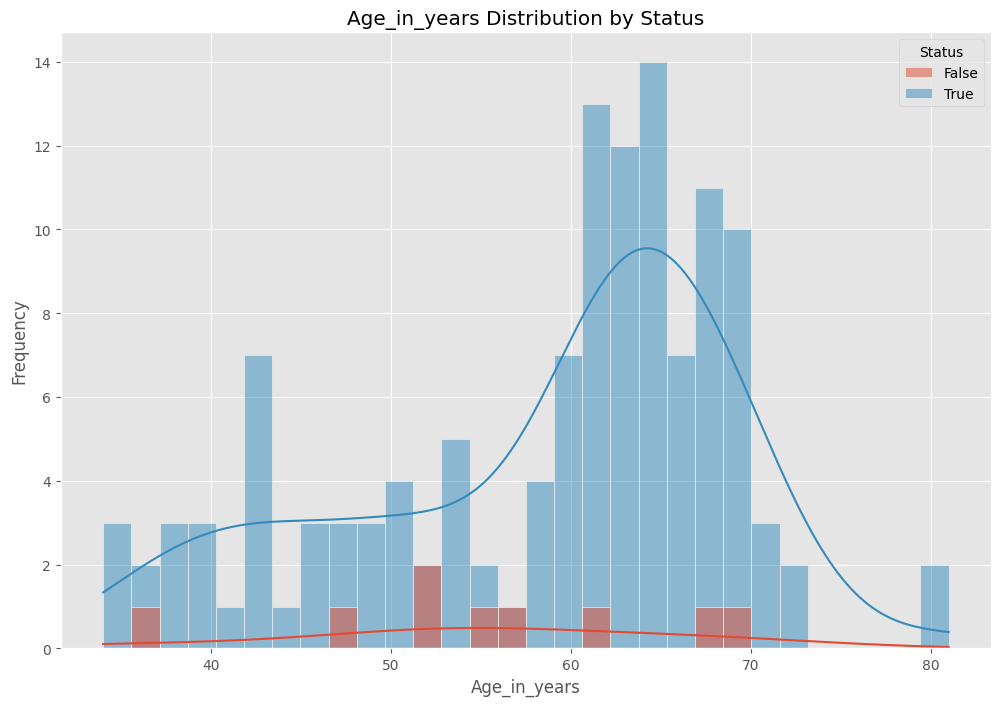

In [15]:
dist_histogram(eda_df, "Age_in_years", color="b", hue_="Status")

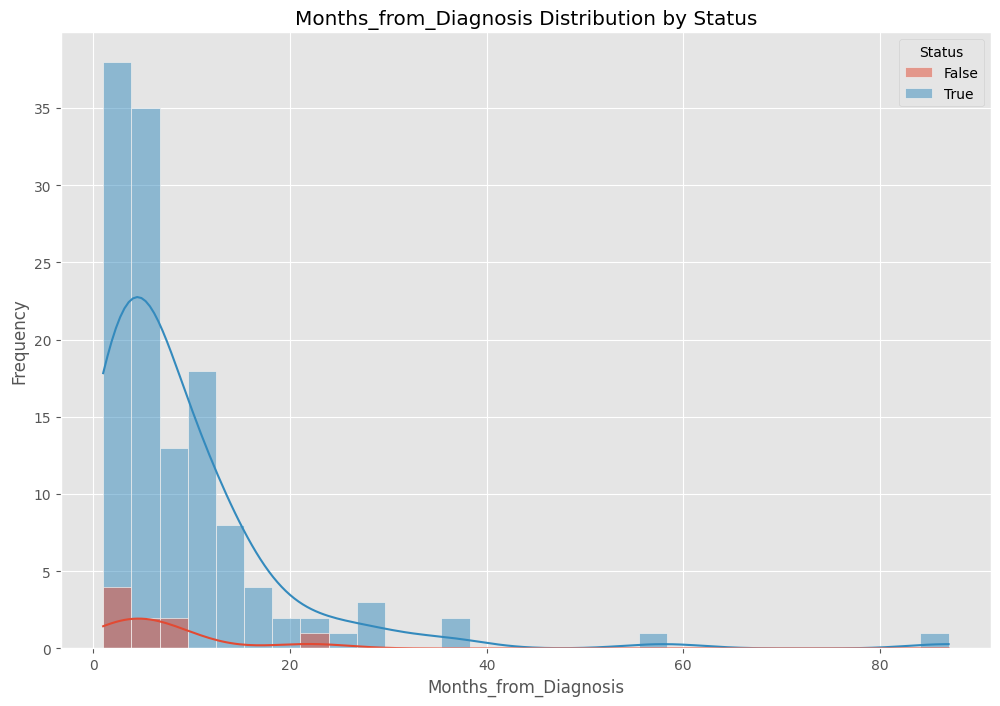

In [17]:
dist_histogram(eda_df, "Months_from_Diagnosis", color="b", hue_="Status")

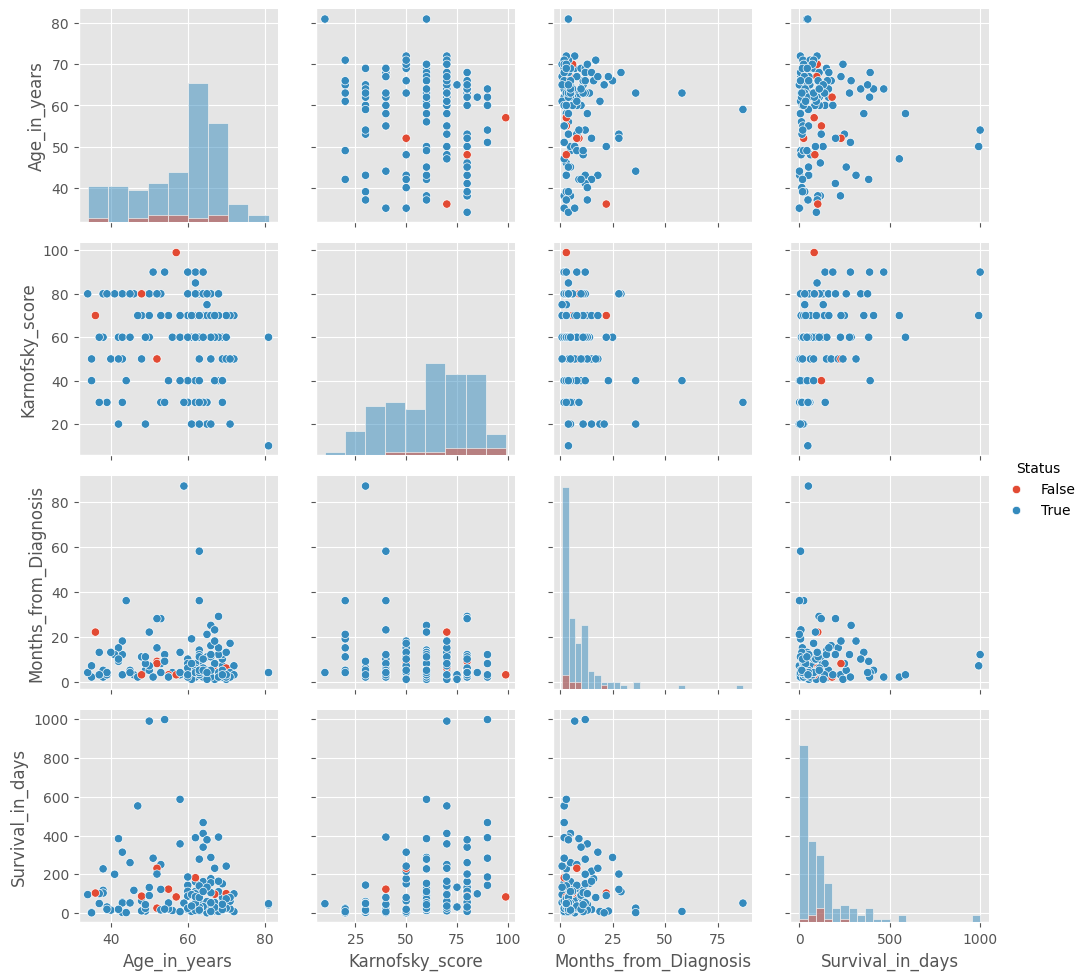

In [19]:
g = sns.PairGrid(eda_df, hue="Status")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

We can see that regretfully, most patients died during the study. For our analysis, this means that most of our data in uncensored as we know when the **event == death** happened.

## Simple survival probability function.

One of the most common methods to analyse survival probability is the [Kaplan Meier Estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator)

In medical research, it is often used to measure the fraction of patients living for a certain amount of time after treatment

Text(0.5, 0, 'time $t$')

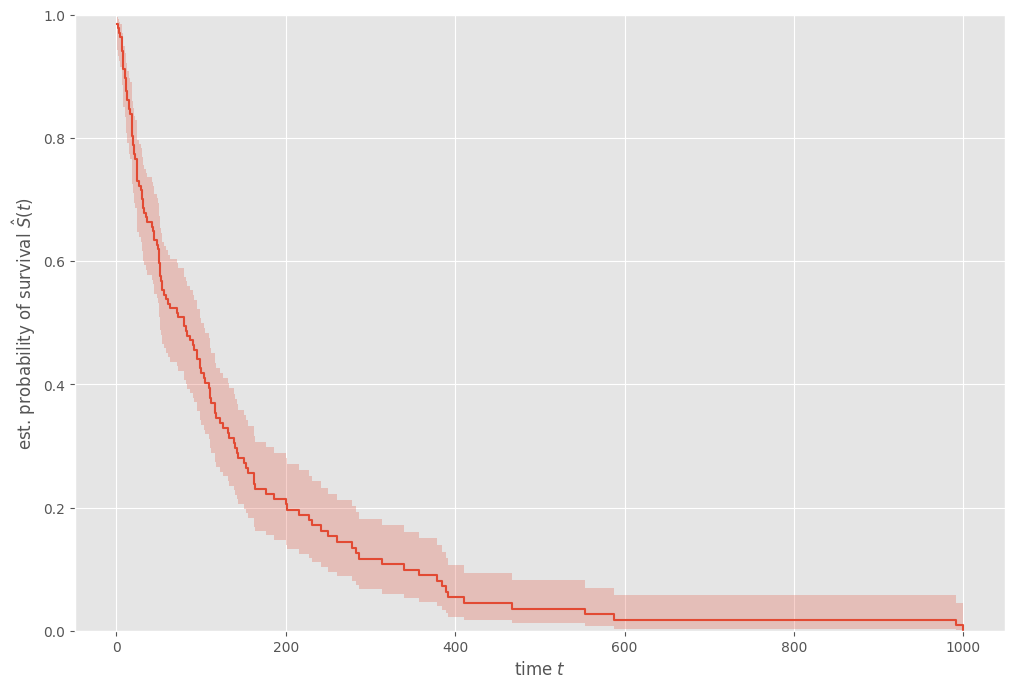

In [21]:

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")


We can see that most patients died at _t200_ (200 days). The elbow curve practically flattens at _t400_

## Adding other variables

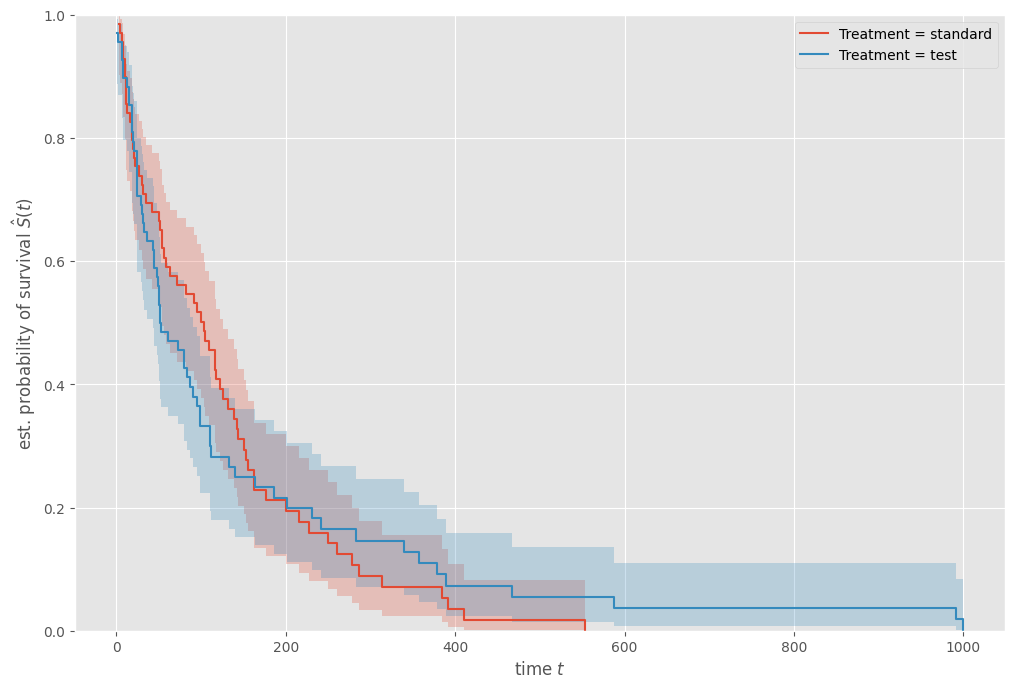

In [22]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Treatment = {treatment_type}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

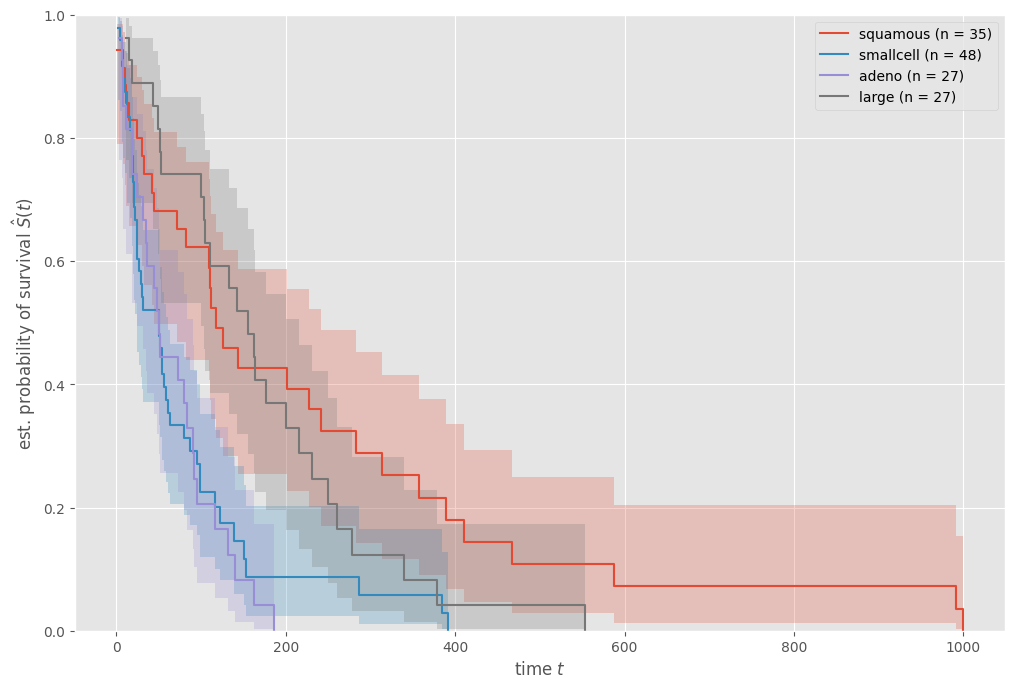

In [25]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        data_y["Status"][mask], data_y["Survival_in_days"][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Multivariate Model

We can build linear estimators similar to a logistic regression, to pin point the drivers that boost or hinder survival in a patient. 

In [27]:
import numpy as np
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [30]:
# let's create 4 new patients. Assuming they just joined the trail. We want to estimate their survival probability

x_new = pd.DataFrame.from_dict(
    {
        1: [65, 0, 0, 1, 60, 1, 0, 1],
        2: [65, 0, 0, 1, 60, 1, 0, 0],
        3: [65, 0, 1, 0, 60, 1, 0, 0],
        4: [65, 0, 1, 0, 60, 1, 0, 1],
    },
    columns=data_x_numeric.columns,
    orient="index",
)
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


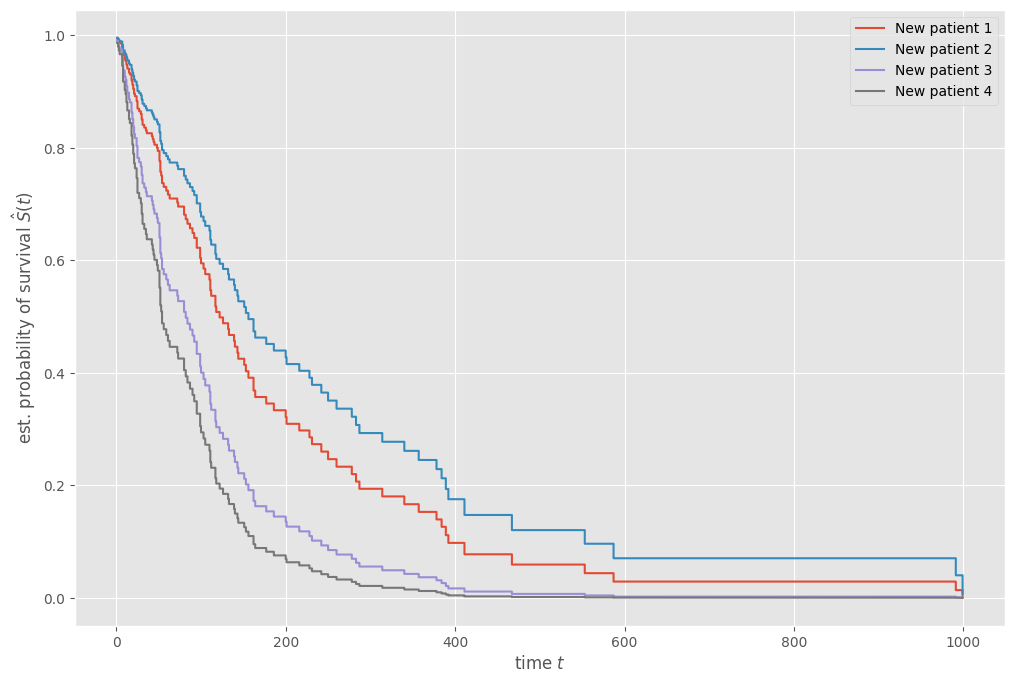

In [31]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)


pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post", label=f"New patient {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

<Axes: >

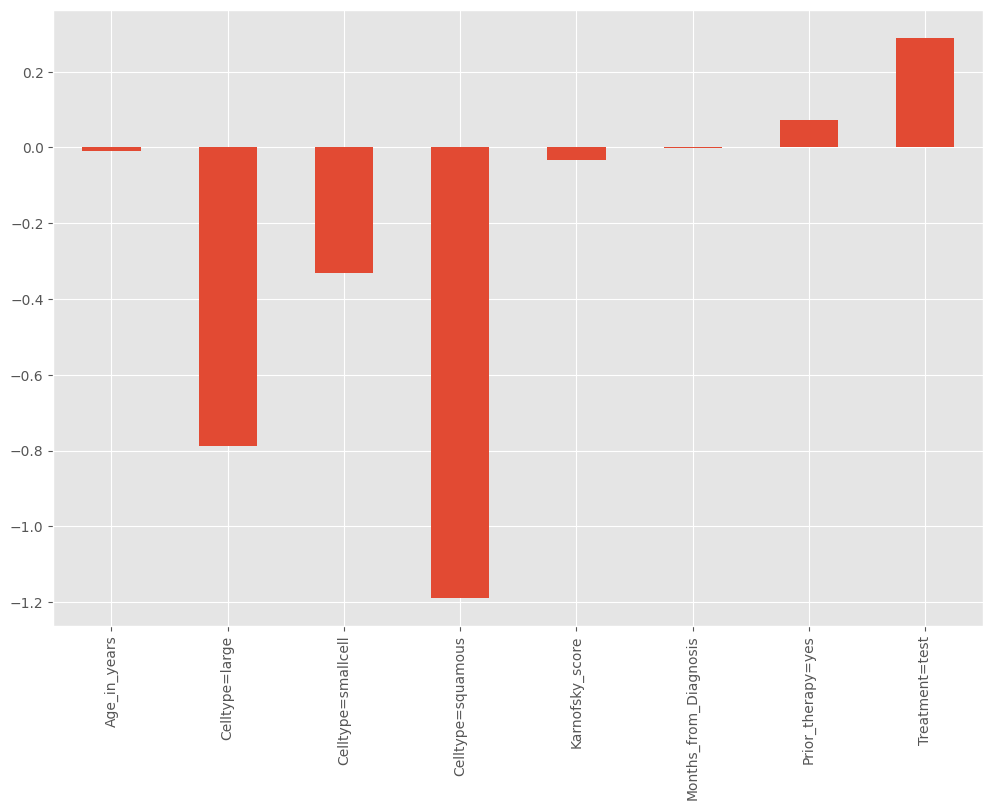

In [33]:
# coefficients 

pd.Series(estimator.coef_, index=data_x_numeric.columns).plot(kind="bar")

Is the treatment (`Treatment == test`) working?

## Evaluation

Evaluation is not as a traditional classification problem, however, Survival Analysis has a metric very similar to the [ROC score](https://www.evidentlyai.com/classification-metrics/explain-roc-curve#:~:text=The%20ROC%20AUC%20score%20can,inadequate%20for%20any%20real%20applications.), called Concordance Index. Its prinicple is basically the same, higher than 0.5 means better than random, a value of 1 means a perfect classifier, values lower than 0.5 means worse than random.

It's of course, embedded in the Scikit-survival Library

In [36]:
round(estimator.score(data_x_numeric, data_y), 2)


0.74